https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

The input to every LSTM layer must be three-dimensional.

(43821, 48)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35061, 3, 8) (35061,)
Train on 8760 samples, validate on 35061 samples
Epoch 1/50
 - 2s - loss: 0.1905 - val_loss: 0.1471
Epoch 2/50
 - 1s - loss: 0.0770 - val_loss: 0.1487
Epoch 3/50
 - 1s - loss: 0.0665 - val_loss: 0.1681
Epoch 4/50
 - 1s - loss: 0.0584 - val_loss: 0.2108
Epoch 5/50
 - 1s - loss: 0.0525 - val_loss: 0.2492
Epoch 6/50
 - 1s - loss: 0.0495 - val_loss: 0.2649
Epoch 7/50
 - 1s - loss: 0.0476 - val_loss: 0.2800
Epoch 8/50
 - 1s - loss: 0.0472 - val_loss: 0.2449
Epoch 9/50
 - 1s - loss: 0.0460 - val_loss: 0.2317
Epoch 10/50
 - 1s - loss: 0.0444 - val_loss: 0.2570
Epoch 11/50
 - 1s - loss: 0.0440 - val_loss: 0.2042
Epoch 12/50
 - 1s - loss: 0.0422 - val_loss: 0.2347
Epoch 13/50
 - 1s - loss: 0.0398 - val_loss: 0.2144
Epoch 14/50
 - 1s - loss: 0.0424 - val_loss: 0.1767
Epoch 15/50
 - 1s - loss: 0.0399 - val_loss: 0.2030
Epoch 16/50
 - 1s - loss: 0.0408 - val_loss: 0.1458
Epoch 17/50
 - 1s - loss: 0.0389 - val_loss: 0.1

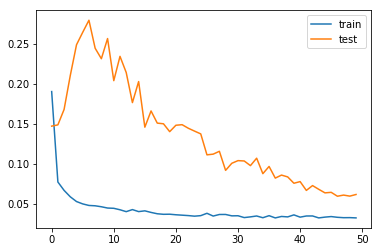

ValueError: operands could not be broadcast together with shapes (35061,8) (12,) (35061,8) 

In [25]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('/Users/kavi/Desktop/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values [:,8] = encoder.fit_transform(values[:,8])

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)